In [1]:
import haversine as hs
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
from sklearn.preprocessing import LabelEncoder
import geopandas as gpd
import xarray as xr
import torch
from torch_geometric.data import Data, Dataset
from Trainer_loocv import Trainer
from wind_utils import get_distance, draw_graph, nearest_neighbors_graph, plot_heatmap, dataset_generation
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
import warnings
warnings.filterwarnings("ignore")

data = xr.open_dataset("data/delhi_cpcb_2022.nc")
# data = xr.open_dataset("delhi_cpcb_2022.nc")
data

<xarray.Dataset>
Dimensions:    (station: 40, time: 8783)
Coordinates:
  * station    (station) object 'Alipur, Delhi - DPCC' ... 'Wazirpur, Delhi -...
  * time       (time) datetime64[ns] 2022-01-01T00:30:00 ... 2023-01-01T22:23:30
    latitude   (station) float64 ...
    longitude  (station) float64 ...
Data variables: (12/21)
    From Date  (station, time) datetime64[ns] ...
    To Date    (station, time) datetime64[ns] ...
    PM2.5      (station, time) float64 ...
    PM10       (station, time) float64 ...
    NO         (station, time) float64 ...
    NO2        (station, time) float64 ...
    ...         ...
    WD         (station, time) float64 ...
    SR         (station, time) float64 ...
    BP         (station, time) float64 ...
    AT         (station, time) float64 ...
    RF         (station, time) float64 ...
    TOT-RF     (station, time) float64 ...

In [2]:
lat_list = [28.815329,28.647622,28.695381,28.4706914,28.7762,28.7256504,28.5512005,28.656756,28.7500499,28.498571,28.5710274,28.655935,28.5627763,28.6811736,28.628624,28.73282,28.58028,28.588333,28.5918245,28.611281,28.636429,28.684678,28.60909,28.570173,28.822836,28.56789,28.6573814,28.530785,28.623763,28.674045,28.639645,28.639645,28.563262,28.732528,28.6514781,28.5504249,28.710508,28.531346,28.672342,28.699793]

In [3]:
df = data.to_dataframe().reset_index()
df = df.dropna(subset=["PM2.5", "WS", "WD"])
df['WD'] = 270-df['WD']

In [4]:
df.head()

,station,time,From Date,To Date,PM2.5,PM10,NO,NO2,NOx,NH3,...,RH,WS,WD,SR,BP,AT,RF,TOT-RF,latitude,longitude
8783,"Anand Vihar, Delhi - DPCC",2022-01-01 00:30:00,2022-01-01 00:00:00,2022-01-01 01:00:00,613.25,NaN,406.70,104.50,387.18,30.1,...,84.15,0.3,97.00,8.95,974.98,11.95,NaN,0.0,28.647622,77.315809
8784,"Anand Vihar, Delhi - DPCC",2022-01-01 01:30:00,2022-01-01 01:00:00,2022-01-01 02:00:00,684.00,892.0,313.38,73.83,294.77,68.2,...,87.62,0.3,49.50,8.88,974.90,11.52,NaN,0.0,28.647622,77.315809
8785,"Anand Vihar, Delhi - DPCC",2022-01-01 02:30:00,2022-01-01 02:00:00,2022-01-01 03:00:00,615.25,916.5,357.10,66.70,325.20,NaN,...,89.38,0.3,54.25,8.88,974.77,11.38,NaN,0.0,28.647622,77.315809
8786,"Anand Vihar, Delhi - DPCC",2022-01-01 03:30:00,2022-01-01 03:00:00,2022-01-01 04:00:00,739.00,950.0,289.57,70.25,273.48,64.4,...,90.65,0.3,68.25,8.90,974.90,11.15,NaN,0.0,28.647622,77.315809
8787,"Anand Vihar, Delhi - DPCC",2022-01-01 04:30:00,2022-01-01 04:00:00,2022-01-01 05:00:00,596.50,801.5,233.18,60.12,222.10,NaN,...,91.33,0.3,48.00,8.88,974.68,11.05,NaN,0.0,28.647622,77.315809


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class ClassificationModel(nn.Module):
    def __init__(self, input_dim):
        super(ClassificationModel, self).__init__()
        self.conv1 = GCNConv(input_dim, 16)
        self.conv2 = GCNConv(16, 10)
        self.linear1 = nn.Linear(10, 10)
        self.linear2 = nn.Linear(10, 5)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        x = self.linear1(x)
        x = torch.relu(x)
        x = self.linear2(x)
        x = F.softmax(x, dim=1)
        return x

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class Trainer:
    """
    Trains the model on the given data for the specified number of epochs.

    Args:
        model (nn.Module): The model to train.
        data (torch_geometric.data.Data): The data to train on.
        epochs (int): The number of epochs to train for.
        device (str): The device to train on.

    """

    def __init__(self, model, data, epochs, device):
        self.model = model
        self.data = data
        self.epochs = epochs
        self.device = device

    def train(self, lr):
        """
        Trains the model.

        """
        self.model.to(self.device)
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)

        for epoch in range(self.epochs):
            optimizer.zero_grad()
            out = self.model(self.data.x.to(self.device), self.data.edge_index.to(self.device))
            loss = criterion(out[self.data.train_mask].squeeze(), self.data.y[self.data.train_mask].squeeze())
            loss.backward()
            optimizer.step()

#             if epoch % 100 == 0:
#                 self.model.eval()
#                 with torch.no_grad():
#                     out = self.model(self.data.x.to(self.device), self.data.edge_index.to(self.device))  # Predicted PM values
#                     train_rmse = torch.sqrt(torch.mean((out[self.data.train_mask].squeeze() - self.data.y[self.data.train_mask].squeeze())**2))
#                     test_rmse = torch.sqrt(torch.mean((out[self.data.test_mask].squeeze() - self.data.y[self.data.test_mask].squeeze())**2))
#                     print(f"Epoch {epoch}: Train RMSE {train_rmse:.4f}, Test RMSE {test_rmse:.4f}")
#                 self.model.train()


In [7]:
def loocv(timestamp):
    dataframe = []
    d = df[df["time"]==timestamp]
    d['PM2.5'] = pd.qcut(df['PM2.5'], q = 5, labels = [0,1,2,3,4])
    G = nearest_neighbors_graph(d, 8)
    node_features, edge_index, y = dataset_generation(G)
    y = y.long()
    
    for super in list(G.nodes()):
#         print(super)
        # Divide train and test masks based on the latitudes
        train_mask = torch.zeros(y.size(0), dtype=torch.bool)
        test_mask = torch.zeros(y.size(0), dtype=torch.bool)
        for j, node in list(enumerate(G.nodes)):
            if node!=super:
                train_mask[j] = True
            else:
                test_mask[j] = True
        
        data = Data(x=torch.tensor(node_features, dtype=torch.float), edge_index=edge_index, y=y,train_mask=train_mask, test_mask = test_mask)
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model = ClassificationModel(4)
        trainer = Trainer(model = model, data = data, device = device, epochs=2500)
        trainer.train(lr=0.001)
        out = model(data.x.to(device), data.edge_index.to(device))  # Predicted PM values
        gnn_pred = out[data.test_mask].argmax(dim = 1)
        gnn_mae = torch.sum(abs(gnn_pred - data.y[data.test_mask].t().squeeze()))
        
        actual = data.y[data.test_mask].squeeze().tolist()
        
        X_train = data.x[data.train_mask].numpy()
        y_train = data.y[data.train_mask].numpy().reshape(-1)
        X_test = data.x[data.test_mask].numpy()
        y_test = data.y[data.test_mask].numpy().reshape(-1)
        
        #RF
        rf_model = RandomForestClassifier(n_estimators=1000, random_state=42)
        rf_model.fit(X_train, y_train)
        rf_pred = rf_model.predict(X_test)
        rf_mae = torch.sum(abs(torch.tensor(rf_pred) - data.y[data.test_mask]))
        
        #KNN
        knn_model = KNeighborsClassifier(n_neighbors = 8)
        knn_model.fit(X_train, y_train)
        knn_pred = knn_model.predict(X_test)
        knn_mae = torch.sum(abs(torch.tensor(knn_pred) - data.y[data.test_mask]))
        
        #Naive Bayes
        nb = GaussianNB()
        nb.fit(X_train, y_train)
        nb_pred = nb.predict(X_test)
        nb_mae = torch.sum(abs(torch.tensor(nb_pred) - data.y[data.test_mask]))
        
        #idw
        idw_model = KNeighborsClassifier(n_neighbors = 8, weights = 'distance')
        idw_model.fit(X_train, y_train)
        idw_pred = idw_model.predict(X_test)
        idw_mae = torch.sum(abs(torch.tensor(idw_pred) - data.y[data.test_mask]))
        
        dataframe.append({
                            "node": G.nodes[super]["station"],
                            "lat": G.nodes[super]["latitude"],
                            "lon": G.nodes[super]["longitude"],
                            "pm": G.nodes[super]["pm"],
                            "WD": G.nodes[super]["wd"],
                            "WS": G.nodes[super]["ws"],
                            "knn mae": float(knn_mae),
                            "idw mae": float(idw_mae),
                            "nb mae": float(nb_mae),
                            "rf mae": float(rf_mae),
                            "gnn mae": float(gnn_mae),
                            "actual": actual,
                            "knn pred": knn_pred[0],
                            "idw pred": idw_pred[0],
                            "nb pred": nb_pred[0],
                            "rf pred": rf_pred[0],
                            "gnn pred": gnn_pred,    
                           })
    
    return dataframe

KNN mae:  0.5
IDW mae:  0.6153846153846154
RF mae:  0.7692307692307693
GNN mae:  0.7692307692307693
NB mae:  0.6923076923076923


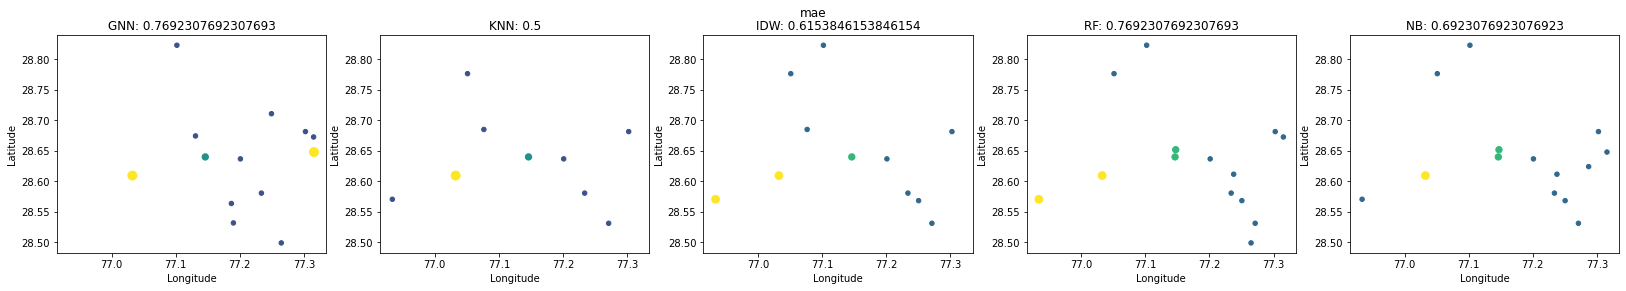

In [8]:
p = pd.date_range(start='2022-03-01 00:30:00', end='2022-08-15 01:30:00', freq = '10M').to_frame(name='dates')

for i in p['dates']:
    d_i = loocv(i)
    d_i = pd.DataFrame(d_i)
    print('KNN mae: ', np.mean(d_i['knn mae']))
    print('IDW mae: ', np.mean(d_i['idw mae']))
    print('RF mae: ', np.mean(d_i['rf mae']))
    print('GNN mae: ', np.mean(d_i['gnn mae']))
    print('NB mae: ', np.mean(d_i['nb mae']))
    
    plt.figure(figsize = (28,4))
    plt.suptitle('mae')
    plt.subplot(1, 5, 1)
    plt.scatter(d_i['lon'], d_i['lat'],  s = 20*d_i['gnn mae'], c = d_i['gnn mae'])
    title = 'GNN: ' + str(np.mean(d_i['gnn mae']))
    plt.title(title)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')

    plt.subplot(1, 5, 2)
    plt.scatter(d_i['lon'], d_i['lat'],  s = 20*d_i['knn mae'], c = d_i['knn mae'])
    title = 'KNN: ' + str(np.mean(d_i['knn mae']))
    plt.title(title)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')

    plt.subplot(1, 5, 3)
    plt.scatter(d_i['lon'], d_i['lat'],  s = 20*d_i['idw mae'], c = d_i['idw mae'])
    title = 'IDW: ' + str(np.mean(d_i['idw mae']))
    plt.title(title)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')

    plt.subplot(1, 5, 4)
    plt.scatter(d_i['lon'], d_i['lat'],  s = 20*d_i['rf mae'], c = d_i['rf mae'])
    title = 'RF: ' + str(np.mean(d_i['rf mae']))
    plt.title(title)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    
    plt.subplot(1, 5, 5)
    plt.scatter(d_i['lon'], d_i['lat'],  s = 20*d_i['nb mae'], c = d_i['nb mae'])
    title = 'NB: ' + str(np.mean(d_i['nb mae']))
    plt.title(title)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()